<a href="https://colab.research.google.com/github/grace-arina/Diagnosing-Pneumonia_CNN/blob/grace-iter-models/first_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gracearina
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:15<00:00, 164MB/s] 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
import shutil

**Generate the Dataset**

In [ ]:
val_pneu_dir = 'chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
val_norm_dir = 'chest-xray-pneumonia/chest_xray/val/NORMAL'

train_pneu_dir = 'chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
train_norm_dir = 'chest-xray-pneumonia/chest_xray/train/NORMAL'

In [ ]:
import os
first_onetwenty_norm = [file for file in os.listdir(train_norm_dir)][0:240]
first_onetwenty_pneumonia = [file for file in os.listdir(train_pneu_dir)][0:240]

for file in first_onetwenty_norm:
    shutil.move(os.path.join(train_norm_dir, file), os.path.join(val_norm_dir, file))

for file in first_onetwenty_pneumonia:
    shutil.move(os.path.join(train_pneu_dir, file), os.path.join(val_pneu_dir, file))

**Data Preprocessing**

Data should be formatted into appropriately preprocessed floatingpoint
tensors before being fed into the network. Currently, the data sits on a drive as
JPEG files, so the steps for getting it into the network are roughly as follows:
1.  Read the picture files.
2.  Decode the JPEG content to RGB grids of pixels.
3.  Convert these into floating-point tensors.
4.  Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
neural networks prefer to deal with small input values).

In [ ]:
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory('./chest-xray-pneumonia/chest_xray/train/',
                                                 target_size=(150, 150),
                                                 #batch_size=20,
                                                 class_mode='binary',
                                                 color_mode='grayscale')

val_set = idg.flow_from_directory('./chest-xray-pneumonia/chest_xray/val/',
                                          target_size=(150, 150),
                                          #batch_size=20,
                                          class_mode='binary',
                                          color_mode='grayscale')

test_set = idg.flow_from_directory('./chest-xray-pneumonia/chest_xray/test/',
                                            target_size=(150, 150),
                                            #batch_size=20,
                                            class_mode='binary', 
                                            color_mode='grayscale')

Found 4736 images belonging to 2 classes.
Found 496 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_set:
  print("Train shape:", data_batch.shape)
  print("Train labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in val_set:
  print("Validation shape:", data_batch.shape)
  print("Validation labels shape:", labels_batch.shape)
  break
for data_batch, labels_batch in test_set:
  print("Test shape:", data_batch.shape)
  print("Test labels shape:", labels_batch.shape)
  break

Train shape: (32, 150, 150, 1)
Train labels shape: (32,)
Validation shape: (32, 150, 150, 1)
Validation labels shape: (32,)
Test shape: (32, 150, 150, 1)
Test labels shape: (32,)


**Example Images From the Dataset**

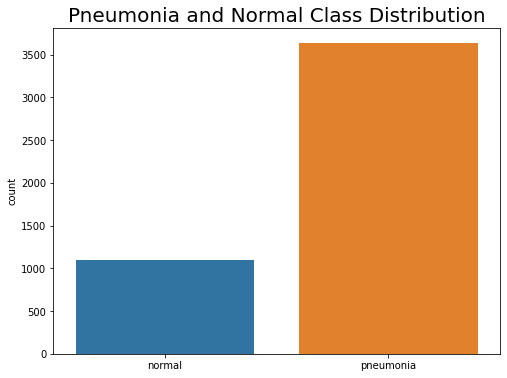

In [ ]:
import seaborn as sns

# Creating a series of the training labels and mapping on readable names
class_labels = pd.Series(train_set.labels).map({0: 'normal', 
                                                   1: 'pneumonia'})

# Plotting the distribution of the classes
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.countplot(x=class_labels)
ax.set_title('Pneumonia and Normal Class Distribution', 
             fontdict={'fontsize': 20});

Each split contains the same number of samples from each class: this is a balanced
binary-classification problem, which means classification accuracy will be an
appropriate measure of success.

**Evaluation Functions for the Models**

In [ ]:
# Pulling out X and y variables from the image sets for visualizing
X_train, y_train = next(train_set)
X_val, y_val = next(val_set)
X_test, y_test = next(test_set)

In [ ]:
def plot_model_metrics(hist, label=''):
    '''
    Generates plots on model metrics from the history.
    
    Args:
        hist (history object): Keras model history object
        label (str): Name of model to be used for titles of graphs
        
    Returns:
        Model history record as a DataFrame
    
    Example:
        plot_model_metrics(history1, label='Base CNN Model')
        
    '''
    
#   Turning history into a DataFrame and saving to local drive
    history_df = pd.DataFrame(hist.history)
    name = label.replace(' ', '')
    history_df.to_csv(f'history{name}.csv')
    
    
#   Defining the training and validation variables    
    train_loss = history_df['loss']
    train_accuracy = history_df['acc']
    train_recall = history_df[history_df.columns[2]]
    val_loss = history_df['val_loss']
    val_accuracy = history_df['val_acc']
    val_recall = history_df[history_df.columns[5]]

#   Plotting the training vs validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy For {label}', fontdict={'fontsize':17})
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
#   Plotting the training vs validation loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss For {label}', fontdict={'fontsize':17})
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
#   Plotting the training vs validation recall
    plt.figure()
    plt.plot(train_recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.title(f'Recall For {label}', fontdict={'fontsize':17})
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    
    return history_df

In [ ]:
from sklearn import metrics

def classification_report(model, y_true=y_test, Xtest=X_test, label=''):
    '''
    Creates a classification report for a model and saves model predictions
    
    Args:
        model (classification model): Keras compatable model
        y_true (array): Test set labels
        Xtest (array): Test set images
        label (str): Name of model to be used for titles
    
    Returns:
        Classification report
    
    Example:
        classification_report(model1, label='Base CNN Model')
    '''
    
#   Generating predictions and saving to CSV file
    y_hat = model.predict(Xtest).round()
    name = label.replace(' ', '')
    prediction_df = pd.DataFrame(y_hat)
    prediction_df.to_csv(f'{name}Predictions.csv')

#   Generating report and printing with nice formating
    print('_____'*12)
    print(f'CLASSIFICATION REPORT FOR: \n\t{label}')
    print('_____'*12)     
    report = metrics.classification_report(y_true, y_hat, 
                                        target_names=['normal', 'pneumonia'])
    print(report)
    print('_____'*12)
    
    return report

In [ ]:
def confusion_matrix(model, y_true=y_test, Xtest=X_test, label=''):
    '''
    Creates a confusion matrix plot with model predictions
    
    Args:
        model (classification model): Keras compatable model
        y_true (array): Test set labels
        Xtest (array): Test set images
        label (str): Name of model to be used for titles
        
    Returns:
        Predictions from model
        
    Example:
        confusion_matrix(model1, label='Base CNN Model')'''
    
#   Generate predictions
    y_hat = model.predict(Xtest).round()
     
#   Plot the confusion matrix as a heatmap
    ax = sns.heatmap(metrics.confusion_matrix(y_true, y_hat, 
                                         normalize='true'), 
                                         cmap='Greens', annot=True, 
                                        xticklabels=['normal', 'pneumonia'], 
                                        yticklabels=['normal', 'pneumonia'])
    
#   Setting labels and title
    ax.set_xlabel('Predicted Label', fontdict={'fontsize':13})
    ax.set_ylabel('True Label', fontdict={'fontsize':13})
    ax.set_title(f'Confusion Matrix For {label}', fontdict={'fontsize':17})
    
    return y_hat

In [ ]:
def evaluate_model(model, hist, y_true=y_test, Xtest=X_test, label=''):
    '''
    Saves model as a file and runs various evaluation functions
    
    Args:
        model (classification model): Keras compatable model
        hist (history object): Keras model history object
        y_true (array): Test set labels
        Xtest (array): Test set images
        label (str): Name of model used for titles
        
    Returns:
        Model
    
    Examples:
        evaluate_model(model1, history1, label='Base CNN Model')
    '''
    
#   Saving model as a file to local drive
    name = label.replace(' ', '')
    model.save(f'{name}.h5')
    
#   Running model evaluation functions
    plot_model_metrics(hist, label=label)
    classification_report(model, y_true=y_true, Xtest=Xtest, label=label)
    confusion_matrix(model, y_true=y_true, Xtest=Xtest, label=label)
    
    return model

## **Building the Baseline Model**

We will start the model with a Rescaling layer, which will
rescale image inputs and the model will have four Conv2D and MaxPooling2D
stages. This serves both to augment the capacity of the model and to further reduce the
size of the feature maps so they aren’t overly large when we reach the Flatten layer. Because we’re looking at a binary-classification problem, we’ll end the model with a
single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the
probability that the model is looking at one class or the other.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

Early stopping will save time with modeling as the model will stop fitting once it is not improving anymore. The monitor for the early stopping will be validation loss as there is a class imbalance so accuracy is not as reliable of a metric with this data. A dictionary of the class weights can be passed when fitting the model to try to adjust for class imbalance.

In [ ]:
from keras.callbacks import EarlyStopping

# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=20, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

In [ ]:
# Building the model
model1 = models.Sequential()
model1.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='same', 
                         activation='relu')) 
#model1.add(layers.MaxPooling2D(2))
#model1.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
#model1.add(layers.MaxPooling2D(2))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

Let’s look at how the dimensions of the feature maps change with every successive
layer:

In [ ]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])


In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      1600      
                                                                 
 flatten_3 (Flatten)         (None, 720000)            0         
                                                                 
 dense_9 (Dense)             (None, 64)                46080064  
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 46,083,777
Trainable params: 46,083,777
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model
history1 = model1.fit(train_set, 
                    validation_data=val_set,
                    steps_per_epoch=100, 
                    epochs=30,
                    callbacks=[earlystop]
                    )

Epoch 1/30
100/100 [==============================] - 123s 1s/step - loss: 0.9496 - acc: 0.8484 - recall_4: 0.9453 - val_loss: 0.2407 - val_acc: 0.9093 - val_recall_4: 0.9637
Epoch 2/30
100/100 [==============================] - 118s 1s/step - loss: 0.1305 - acc: 0.9541 - recall_4: 0.9739 - val_loss: 0.3019 - val_acc: 0.8851 - val_recall_4: 0.9879
Epoch 3/30
100/100 [==============================] - 116s 1s/step - loss: 0.1308 - acc: 0.9484 - recall_4: 0.9692 - val_loss: 0.2059 - val_acc: 0.9274 - val_recall_4: 0.9798
Epoch 4/30
100/100 [==============================] - 114s 1s/step - loss: 0.0714 - acc: 0.9728 - recall_4: 0.9842 - val_loss: 0.1361 - val_acc: 0.9476 - val_recall_4: 0.9677
Epoch 5/30
100/100 [==============================] - 116s 1s/step - loss: 0.0524 - acc: 0.9828 - recall_4: 0.9883 - val_loss: 0.1624 - val_acc: 0.9476 - val_recall_4: 0.9839
Epoch 6/30
100/100 [==============================] - 121s 1s/step - loss: 0.0386 - acc: 0.9872 - recall_4: 0.9919 - val_loss

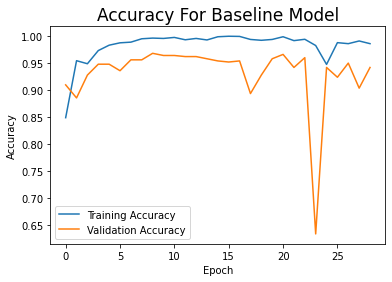

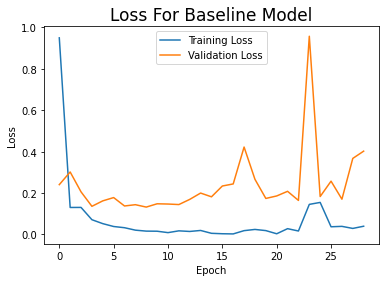

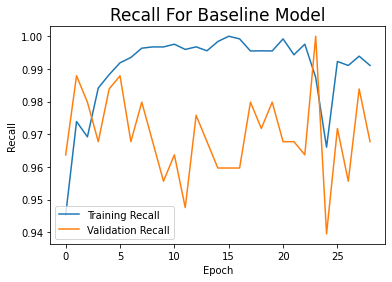

____________________________________________________________
CLASSIFICATION REPORT FOR: 
	Baseline Model
____________________________________________________________
              precision    recall  f1-score   support

      normal       0.67      0.40      0.50         5
   pneumonia       0.90      0.96      0.93        27

    accuracy                           0.88        32
   macro avg       0.78      0.68      0.71        32
weighted avg       0.86      0.88      0.86        32

____________________________________________________________


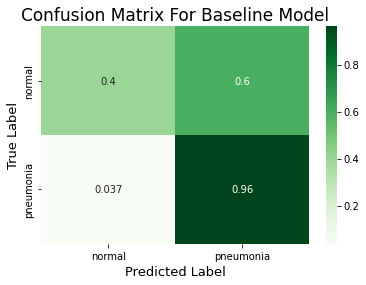

In [ ]:
# Running the evaluation function
evaluate_model(model=model1, hist=history1, label='Baseline Model')

In [ ]:
model1.evaluate(test_set)

20/20 [==============================] - 9s 446ms/step - loss: 1.8677 - acc: 0.7372 - recall_4: 0.9923


[1.867653727531433, 0.7371794581413269, 0.9923076629638672]

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64, 3, strides=2, input_shape=(150,150,1), activation="relu", padding="same"))
model2.add(layers.Conv2D(64, 3, activation="relu", padding="same"))
model2.add(layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"))
model2.add(layers.Conv2D(128, 3, activation="relu", padding="same"))
model2.add(layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"))
model2.add(layers.Conv2D(256, 3, activation="relu", padding="same"))
model2.add(layers.Conv2DTranspose(256, 3, activation="relu", padding="same"))
model2.add(layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2))
'''model2.add(layers.Conv2DTranspose(128, 3, activation="relu", padding="same"))
model2.add(layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2))
model2.add(layers.Conv2DTranspose(64, 3, activation="relu", padding="same"))
model2.add(layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2))'''
model2.add(layers.Conv2D(32, 3, activation="softmax",padding="same"))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 75, 75, 64)        640       
                                                                 
 conv2d_42 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 conv2d_43 (Conv2D)          (None, 38, 38, 128)       73856     
                                                                 
 conv2d_44 (Conv2D)          (None, 38, 38, 128)       147584    
                                                                 
 conv2d_45 (Conv2D)          (None, 19, 19, 256)       295168    
                                                                 
 conv2d_46 (Conv2D)          (None, 19, 19, 256)       590080    
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 19, 19, 256)     

In [ ]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])


In [ ]:
# Fitting the model
history2 = model2.fit(train_set, 
                    validation_data=val_set,
                    steps_per_epoch=100, 
                    epochs=30,
                    callbacks=[earlystop]
                    )

Epoch 1/30
100/100 [==============================] - 655s 7s/step - loss: 0.5625 - acc: 0.7663 - recall_11: 0.9903 - val_loss: 0.8288 - val_acc: 0.5000 - val_recall_11: 1.0000
Epoch 2/30
100/100 [==============================] - 649s 6s/step - loss: 0.5559 - acc: 0.7716 - recall_11: 1.0000 - val_loss: 0.7894 - val_acc: 0.5000 - val_recall_11: 1.0000
Epoch 3/30
100/100 [==============================] - 638s 6s/step - loss: 0.5545 - acc: 0.7644 - recall_11: 1.0000 - val_loss: 0.8104 - val_acc: 0.5000 - val_recall_11: 1.0000
Epoch 4/30
100/100 [==============================] - 639s 6s/step - loss: 0.5434 - acc: 0.7694 - recall_11: 1.0000 - val_loss: 0.9038 - val_acc: 0.5000 - val_recall_11: 1.0000
Epoch 5/30
100/100 [==============================] - 650s 6s/step - loss: 0.5489 - acc: 0.7650 - recall_11: 1.0000 - val_loss: 0.8415 - val_acc: 0.5000 - val_recall_11: 1.0000
Epoch 6/30
100/100 [==============================] - 646s 6s/step - loss: 0.5529 - acc: 0.7656 - recall_11: 1.0000

In [1]:
evaluate_model(model=model1, hist=history2, label='Second Model')

NameError: ignored

In [2]:
model2.evaluate(test_set)

NameError: ignored

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculating the class weights
weights = compute_class_weight('balanced', np.unique(training_set.labels), 
                               train_set.labels)
weights

In [ ]:
# Zipping the class weights into a dictionary
weights = dict(zip(np.unique(train_set.labels), weights))
weights

In [ ]:
# Building the model
model3 = models.Sequential()
model3.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='same', 
                         activation='relu')) 
model3.add(layers.MaxPooling2D(2))
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D(2))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compiling the model and looking at the summary
model3.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', tf.metrics.Recall()])
model3.summary()

In [ ]:
# Fitting the model
history3 = model3.fit(train_set, 
                    validation_data=val_set,
                    steps_per_epoch=100, 
                    epochs=30,
                    class_weight=weights,
                    callbacks=[earlystop]
                    )

In [ ]:
# Running the evaluation function
evaluate_model(model=model3, hist=history3, label='Class Weights Model')

In [ ]:
model3.evaluate(test_set)